In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from matplotlib.pyplot import figure
from pdf_fitter import *
from LNPL_functions import *
from scipy.optimize import minimize
%matplotlib inline

We are given an .npz file, which is a numpy zipped file, and need to load and read it into the notebook. We find it has several named columns, so we seperate the data accordingly as seen in the process below.

In [ ]:
data = np.load("/content/feedback.npz",mmap_mode='r') # Loading the numpy zipped file as a variable data.
Xarray0 = data['xdata_f0'] # Seperating the array of data by its columns into X, Y, and uncertainty arrays for each efficency percentage provided.
Xarray2 = data['xdata_f2']
Xarray5 = data['xdata_f5']

Yarray0 = data['counts_f0']
Yarray2 = data['counts_f2']
Yarray5 = data['counts_f5']

Uncertainty0 = data['y_sigma_0']
Uncertainty2 = data['y_sigma_2']
Uncertainty5 = data['y_sigma_5']

It's always a good idea to visualize the data before working with it, so in the step below we plot them on a graph with a log scale y axis. This graph can then be compared to the source paper, here we see that the 5% SFE has a hump very early on, and this is reflected in All+Outflows of figure 3 in Appel 2021, confirming that we are set up correctly.

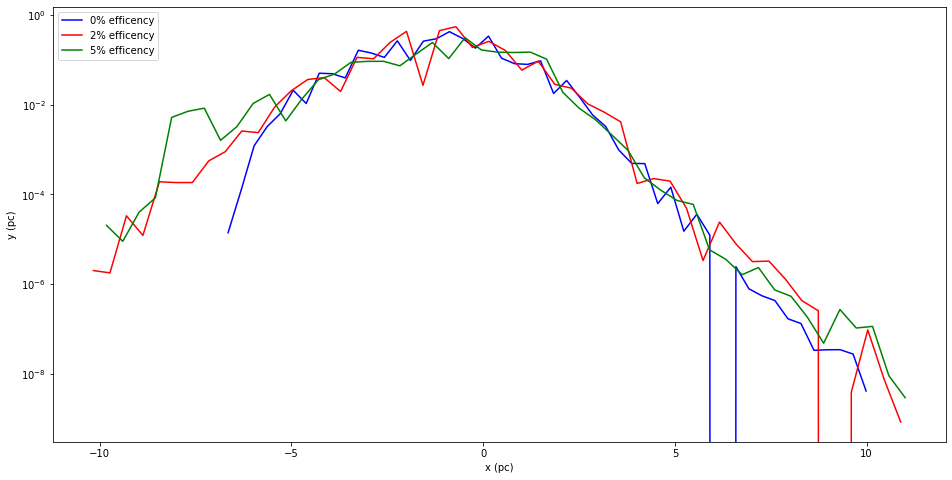

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(Xarray0, Yarray0, color='blue', label = '0% efficency')
plt.plot(Xarray2, Yarray2, color='red', label = '2% efficency')
plt.plot(Xarray5, Yarray5, color='green', label = '5% efficency')
plt.legend(loc='upper left')
plt.xlabel("x (pc)")
plt.ylabel("y (pc)")
plt.yscale('log')
plt.show() # plotting the data directly in a logarithmic y scale it visualize the data.

We are initially given the y data, but we need to find the y model as well to create the chi squared function. From Khullar's PDF Fit package we are able to use the lognormal + power law function to run our given x data and output the y model that we need.

Then we do the chi squared function, which will take in the x and y data and output a distribution of the sum of the random variables.

Notice that there is a boundary condition given near the bottom, requiring parameters to be within a certain minimum and maximum value.

In [ ]:
def model_y(xdata, sigma_s, alpha):
  m_y = LNPLfunction(xdata, sigma_s, alpha) # This function takes in a given array of x values 
  # and uses the Khullar package to do the lognormal + power law, returning y values which we interpret at the model.
  return m_y

def chi_squared(parameters, xdata, ydata, uncertainty): # The chi squared function which we use to difference between the model parameters and the data parameters over the uncertainty.
  sigma_s, alpha = parameters # The parameters that the chi squared function will attempt to work with.
  def given(a):
    d_y = ydata[a]
    unc = uncertainty[a]
    m_y = model_y(xdata[a], sigma_s, alpha)
    return (d_y - m_y)**2 / unc**2 # Modeling the data minus model squared over uncertainty squared.
  chi = 0
  for x in range(len(ydata)):
    chi += given(x)
  if sigma_s > 4.0 or sigma_s < 1.0 or alpha > 4.0 or alpha < 1.0: #Boundaries so that the function doesn't take into consideration sigma and alpha values below 1 and above 4, and returns a high chi value if they are out of bounds
    chi = 10e10
  return chi

We then use scipy minimize to minimize the chi squared over the given variables. This outputs the value of the function minimized, whether it was a success, and an array of the sigma and alpha values it minimized to.

This information is further graphed to highlight how similar or distant the y data is from the y model, also in log scale y axis.

This is then repeated for 2 more cells with the other SFE values.

 final_simplex: (array([[1.36871285, 2.0239821 ],
       [1.36870751, 2.02394353],
       [1.36873451, 2.02397109]]), array([2757.70260285, 2757.70260858, 2757.70263081]))
           fun: 2757.7026028498676
       message: 'Optimization terminated successfully.'
          nfev: 62
           nit: 32
        status: 0
       success: True
             x: array([1.36871285, 2.0239821 ])


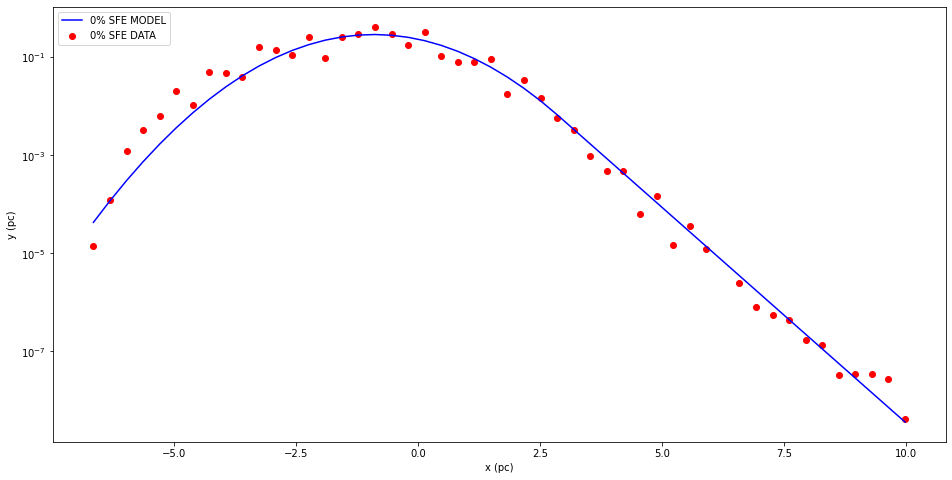

In [ ]:
SFE0 = minimize(chi_squared, [1.5, 2], (Xarray0, Yarray0, Uncertainty0), method = "Nelder-Mead") # Using scipy minimize to find parameters values for when the function is at its smallest.
print(SFE0) # Printing the result of the minimization which tells us the function value at its minimum based on our estimated values, and an array of our parameters minimized.
m_y0 = LNPLfunction(Xarray0, SFE0.x[0], SFE0.x[1])
plt.figure(figsize=(16,8))
plt.plot(Xarray0, m_y0, color='blue', label = '0% SFE MODEL') # Plotting the existing x values for this specific SFE percentage against both the data y values and model y values.
plt.scatter(Xarray0, Yarray0, color='red', label = '0% SFE DATA')
plt.xlabel("x (pc)")
plt.ylabel("y (pc)")
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

 final_simplex: (array([[1.45256872, 1.86846688],
       [1.45251449, 1.86845827],
       [1.45258372, 1.86850224]]), array([1274.97002132, 1274.9700452 , 1274.97009793]))
           fun: 1274.9700213207448
       message: 'Optimization terminated successfully.'
          nfev: 60
           nit: 32
        status: 0
       success: True
             x: array([1.45256872, 1.86846688])


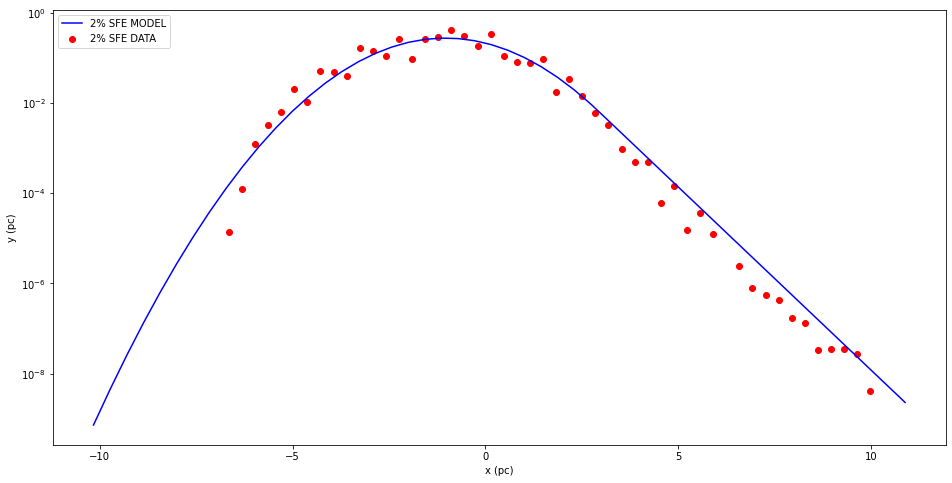

In [ ]:
SFE2 = minimize(chi_squared, [1.5, 2], (Xarray2, Yarray2, Uncertainty2), method = "Nelder-Mead") #Very similar process as above, but with 2% SFE.
print(SFE2)
m_y2 = LNPLfunction(Xarray2, SFE2.x[0], SFE2.x[1])
plt.figure(figsize=(16,8))
plt.plot(Xarray2, m_y2, color='blue', label = '2% SFE MODEL')
plt.scatter(Xarray0, Yarray0, color='red', label = '2% SFE DATA')
plt.xlabel("x (pc)")
plt.ylabel("y (pc)")
plt.legend(loc='upper left')
plt.yscale('log') # log scale on the y axis to be consist with the initial data visualization of all efficiencies.
plt.show()

 final_simplex: (array([[1.77907946, 3.99999978],
       [1.77907947, 3.99998244],
       [1.7790795 , 3.99993094]]), array([5475.20893923, 5475.20894797, 5475.20899091]))
           fun: 5475.208939226531
       message: 'Optimization terminated successfully.'
          nfev: 166
           nit: 89
        status: 0
       success: True
             x: array([1.77907946, 3.99999978])


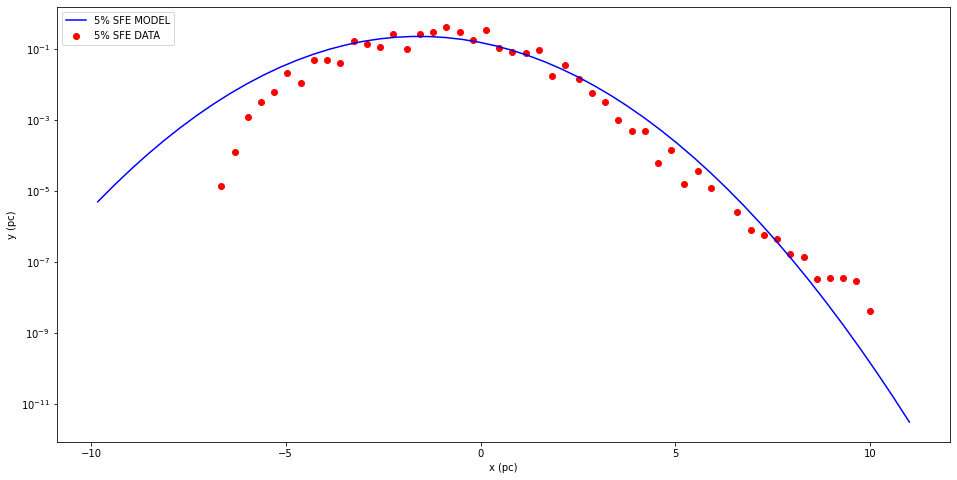

In [ ]:
SFE5 = minimize(chi_squared, [1.8, 2], (Xarray5, Yarray5, Uncertainty5), method = "Nelder-Mead") #Done again, but with 5% SFE.
print(SFE5)
m_y5 = LNPLfunction(Xarray5, SFE5.x[0], SFE5.x[1])
plt.figure(figsize=(16,8))
plt.plot(Xarray5, m_y5, color='blue', label = '5% SFE MODEL')
plt.scatter(Xarray0, Yarray0, color='red', label = '5% SFE DATA')
plt.xlabel("x (pc)")
plt.ylabel("y (pc)")
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

Now that we have the chi squared minimize, we now need to do MCMC to sample the probablity distrubtion we got from the chi squared. This is where the loglikelyhood function comes in, to see how well the model fits the data, visualized with walker chains.

For us, its important to see where the walkers end up, rather than where they started. This is done using 10 walkers over 5000 steps with several burn in runs to ensure that the results are not skewed because of their initial starting values. Below we see that parameter 1, sigma, converges to around 1.3, and alpha is around 2.02, both with negligible uncertainties.

This is then highlighted further in the corner plot below the walker cell, in which we see a probability distribution for our given parameters.

burn-in run
main run


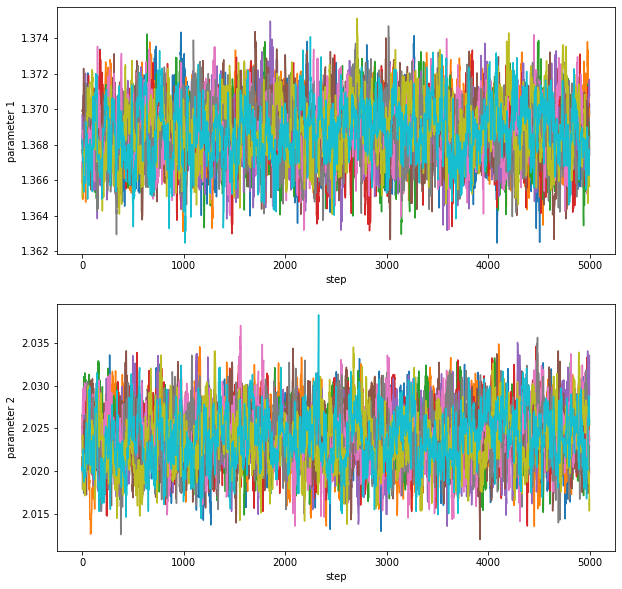

In [ ]:
def loglikelyhood(parameters, xdata, ydata, uncertainty):
  return -0.5*chi_squared(parameters, xdata, ydata, uncertainty) # This is the function for the log likelyhood which we will need for the walkers to observe how well the model fits the data.

ndim = 2 # The two dimensions are for our two parameters, sigma and alpha.
nwalk = 10 # The amount of walkers we want
nburn = 200 # The burn in value for walkers
nmain = 5000 # The amount of steps we want the walkers to take over the given data.
# random starting points; we will take the strategy of perturbing some starting point
pstart = np.array([1.2,1.5])
p0 = np.array([ pstart+1.0e-4*np.random.normal(size=ndim) for iwalk in range(nwalk) ])
# set up the sampler
sampler1 = emcee.EnsembleSampler(nwalk,ndim,loglikelyhood, args=(Xarray0, Yarray0, Uncertainty0,))
# burn-in run
print('burn-in run')
pos,prob,state,other = sampler1.run_mcmc(p0,nburn)
# reset the sampler
sampler1.reset()
# main run
print('main run')
res = sampler1.run_mcmc(pos,nmain)
samples = sampler1.chain.reshape((-1,ndim))

f,ax = plt.subplots(ndim,1,figsize=(10,10))
for idim in range(ndim):
  for iwalk in range(nwalk):
    ax[idim].plot(sampler1.chain[iwalk,:,idim])
  ax[idim].set_xlabel('step')
  ax[idim].set_ylabel('parameter {}'.format(idim+1)) # Plotting the result of the walkers, and seeing if they stabalize towards some value for the parameter.
f.show()

Corner Plot for 0% SFE


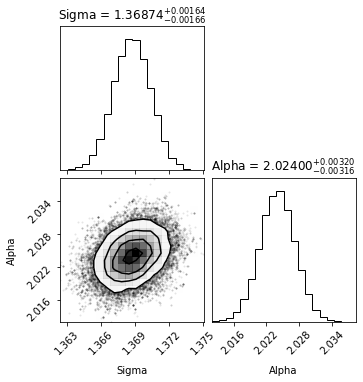

In [ ]:
print("Corner Plot for 0% SFE")
f = corner.corner(samples,show_titles=True,labels=('Sigma','Alpha'),title_fmt='.5f') # The corner plot displays a probability distribution of our parameter.
f.show()

burn-in run
main run


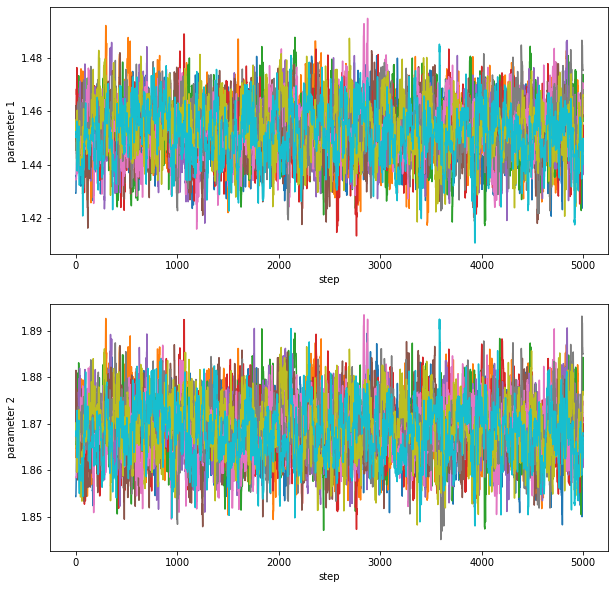

In [ ]:
ndim = 2
nwalk = 10
nburn = 200
nmain = 5000
# random starting points; we will take the strategy of perturbing some starting point
pstart = np.array([1.2,1.5])
p0 = np.array([ pstart+1.0e-4*np.random.normal(size=ndim) for iwalk in range(nwalk) ])
# set up the sampler
sampler2 = emcee.EnsembleSampler(nwalk,ndim,loglikelyhood, args=(Xarray2, Yarray2, Uncertainty2,))
# burn-in run
print('burn-in run')
pos,prob,state,other = sampler2.run_mcmc(p0,nburn)
# reset the sampler
sampler2.reset()
# main run
print('main run')
res = sampler2.run_mcmc(pos,nmain)
samples2 = sampler2.chain.reshape((-1,ndim))

f,ax = plt.subplots(ndim,1,figsize=(10,10))
for idim in range(ndim):
  for iwalk in range(nwalk):
    ax[idim].plot(sampler2.chain[iwalk,:,idim])
  ax[idim].set_xlabel('step')
  ax[idim].set_ylabel('parameter {}'.format(idim+1))
f.show()

Corner Plot for 2% SFE


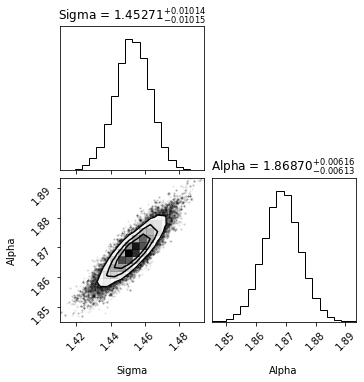

In [ ]:
print("Corner Plot for 2% SFE")
f = corner.corner(samples2,show_titles=True,labels=('Sigma','Alpha'),title_fmt='.5f')
f.show()

burn-in run
main run


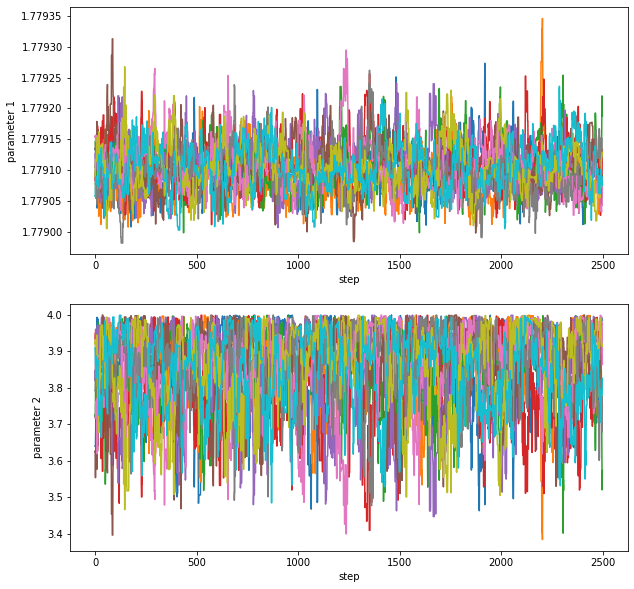

In [ ]:
def loglikelyhood(parameters, xdata, ydata, uncertainty):
  return -0.5*chi_squared(parameters, xdata, ydata, uncertainty)

ndim = 2
nwalk = 10
nburn = 400
nmain = 2500
# random starting points; we will take the strategy of perturbing some starting point
pstart = np.array([1.2,1.5])
p0 = np.array([ pstart+1.0e-4*np.random.normal(size=ndim) for iwalk in range(nwalk) ])
# set up the sampler
sampler3 = emcee.EnsembleSampler(nwalk,ndim,loglikelyhood, args=(Xarray5, Yarray5, Uncertainty5,))
# burn-in run
print('burn-in run')
pos,prob,state,other = sampler3.run_mcmc(p0,nburn)
# reset the sampler
sampler3.reset()
# main run
print('main run')
res = sampler3.run_mcmc(pos,nmain)
samples3 = sampler3.chain.reshape((-1,ndim))

f,ax = plt.subplots(ndim,1,figsize=(10,10))
for idim in range(ndim):
  for iwalk in range(nwalk):
    ax[idim].plot(sampler3.chain[iwalk,:,idim])
  ax[idim].set_xlabel('step')
  ax[idim].set_ylabel('parameter {}'.format(idim+1))
f.show()

Corner Plot for 5% SFE


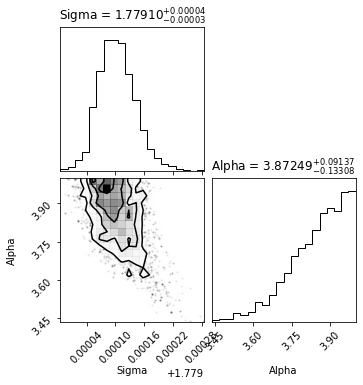

In [ ]:
print("Corner Plot for 5% SFE")
f = corner.corner(samples3,show_titles=True,labels=('Sigma','Alpha'),title_fmt='.5f')
f.show()